# Notebook para código de pruebas, checks y anotaciones

Chequear si las probabilidades aleatorias del choose_action() funcionan bien.

In [2]:
import numpy as np

"""probs = [[0.0040233,  0.847307,   0.14866969],
 [0.7979448,  0.15856983, 0.0434854 ],
 [0.5554874 , 0.34591073 ,0.09860188],
 [0.2927103  ,0.50127864, 0.2060111 ],
 [0.11640792, 0.45406437 ,0.4295277 ]]
"""
probs = [[0.48661566, 0.42588234, 0.087502  ],
 [0.19536212, 0.3296347 , 0.47500318],
 [0.37989447 ,0.37718463 ,0.24292094],
 [0.2112374 , 0.5596584 , 0.22910419],
 [0.31614146, 0.39353094, 0.2903276 ]]

sum_probs = []
for p in probs:
    sum_probs.append(np.sum(p))

print(sum_probs)

[1.0, 1.0, 1.00000004, 0.9999999900000001, 1.0]


## Creando la red encargada de distinguir herramientas

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os

class ObserverNetwork(nn.Module):
    # Devuelve la acción a tomar en función del estado
    def __init__(self, input_dims, n_actions, n_choices_per_finger, conv_channels=[16, 32, 64], hidden_size=256, name='observer', checkpoint_dir='Desarrollo/simulation/Env03/tmp/observer', learning_rate=0.001):
        super(ObserverNetwork, self).__init__()
        self.input_dims = input_dims
        self.checkpoint_dir = checkpoint_dir
        self.name = name
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name+'_td3')

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=conv_channels[0], kernel_size=5, stride=2, padding=2)
        self.conv2 = nn.Conv2d(in_channels=conv_channels[0], out_channels=conv_channels[1], kernel_size=5, stride=2, padding=2)
        self.conv3 = nn.Conv2d(in_channels=conv_channels[1], out_channels=conv_channels[2], kernel_size=5, stride=2, padding=2)
        self.fc1 = nn.Linear(conv_channels[2] * (input_dims[0] // 8) * (input_dims[1] // 8), hidden_size)
        self.fc2 = nn.Linear(hidden_size, 5)
        self.fc3 = nn.Linear(5, 1)
        
        self.optimizer = optim.AdamW(self.parameters(), lr=learning_rate)
        
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        print(f"Created Actor Network on device: {self.device}")
        self.to(self.device)
        

    def forward(self, img):
        img = img.to(self.device)
        x = F.leaky_relu(self.conv1(img))
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv3(x))
        #print(f"Shape after conv3: {x.shape}")
        # Check if the input is a batch or a single image
        if len(x.shape) == 4:  # Batch case: [batch_size, channels, height, width]
            x = x.reshape((x.size(0), -1))  # Flatten each sample in the batch
        elif len(x.shape) == 3:  # Single image case: [channels, height, width]
            x = x.reshape(-1)  # Flatten the single image
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        tool_reg = F.leaky_relu(self.fc3(x))
            
        return tool_reg # Tool regresion

    def save_checkpoint(self):
        torch.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(torch.load(self.checkpoint_file))

In [11]:
combinations = {
    "Combination 1": [2, 1, 2, 2, 2],  # Thumb closed, index half, others closed
    "Combination 2": [2, 1, 1, 2, 2],  # Thumb closed, index and middle half, others open
    "Combination 3": [1, 1, 1, 1, 1],     # All fingers half closed
    "Combination 4": [0, 0, 0, 0, 0],           # All fingers opened
    "Weird Combination": None,              # Any other combination
}

dict(list(combinations.items())[:-1])

{'Combination 1': [2, 1, 2, 2, 2],
 'Combination 2': [2, 1, 1, 2, 2],
 'Combination 3': [1, 1, 1, 1, 1],
 'Combination 4': [0, 0, 0, 0, 0]}

Ver cuantos pixeles blancos tiene cada herramienta

In [6]:
import os
import numpy as np
import cv2

image_dir = "/home/pablo_kevin/ProyectoTecnologo_RoboticHandDRL/Desarrollo/simulation/Env03/DataSets/B&W_Tools"
tools_of_interest = [f for f in os.listdir(image_dir)]

for tool in tools_of_interest:
    selected_image_path = os.path.join(image_dir, tool)
    img = cv2.imread(selected_image_path, cv2.IMREAD_GRAYSCALE)
    n_white_pixels = len(np.argwhere(img == 255))
    print(tool, ", white_pixels/1000 =", n_white_pixels/1000, ", [min,max] with scale:", [n_white_pixels*0.9/1000, n_white_pixels*1.2/1000])

bw_Lapicera01.png , white_pixels/1000 = 1.38 , [min,max] with scale: [1.242, 1.656]
bw_destornillador02.png , white_pixels/1000 = 3.225 , [min,max] with scale: [2.9025, 3.87]
bw_destornillador01.jpg , white_pixels/1000 = 2.732 , [min,max] with scale: [2.4588, 3.2784]
bw_martillo02.png , white_pixels/1000 = 6.885 , [min,max] with scale: [6.1965, 8.262]
bw_pinza_chica01.png , white_pixels/1000 = 1.088 , [min,max] with scale: [0.9792000000000001, 1.3055999999999999]
bw_Martillo01.jpg , white_pixels/1000 = 6.363 , [min,max] with scale: [5.7267, 7.635599999999999]
bw_tornillo02.png , white_pixels/1000 = 0.611 , [min,max] with scale: [0.5498999999999999, 0.7332]
bw_destornillador03.png , white_pixels/1000 = 3.58 , [min,max] with scale: [3.222, 4.296]
bw_calibre01.png , white_pixels/1000 = 4.672 , [min,max] with scale: [4.2048000000000005, 5.6064]
bw_lapicera02.png , white_pixels/1000 = 2.041 , [min,max] with scale: [1.8369000000000002, 2.4492]
empty.png , white_pixels/1000 = 0.0 , [min,max] 

In [17]:
class Finger():
    def __init__(self, name, upper_lims, lower_lims=None, positions=None, position_max=2.0):
        self.name = name
        self.upper_lims = upper_lims
        if lower_lims is None:
            self.lower_lims=[0.0 for _ in range(len(upper_lims))]
        else:
            self.lower_lims=lower_lims
        self.joint_names = [f"{name}_joint{joint}" for joint in range(len(upper_lims))]
        if positions is None:
            self.positions = [0.0 for _ in range(len(upper_lims))]
        else:
            self.positions = positions
        self.position_max=position_max

    def action(self, position):
        positions = []
        for i in range(len(self.positions)):
            positions.append((position*(self.upper_lims[i]-self.lower_lims[i])/self.position_max)+self.lower_lims[i])
        self.positions=positions
        return positions


In [18]:
indice = Finger("indice", upper_lims=[-1.281, -1.305, -1.224])
print(indice.action(0.0))
print(indice.action(1.0))
print(indice.action(2.0))

pulgar = Finger("pulgar", upper_lims=[-1.569, -0.806], lower_lims=[0.0, 0.395])
print(pulgar.action(0.0))
print(pulgar.action(1.0))
print(pulgar.action(2.0))

[0.0, 0.0, 0.0]
[-0.6405, -0.6525, -0.612]
[-1.281, -1.305, -1.224]
[0.0, 0.395]
[-0.7845, -0.20550000000000002]
[-1.569, -0.806]


In [27]:
class Hand():
    def __init__(self, pulgar, indice, medio, anular, menique):
        self.pulgar = pulgar
        self.indice = indice
        """self.medio = medio
        self.anular = anular
        self.menique = menique"""
        self.joint_names = [*pulgar.joint_names, *indice.joint_names]
        self.joint_positions = [*pulgar.positions, *indice.positions]

In [26]:
indice = Finger("indice", upper_lims=[-1.281, -1.305, -1.224])
pulgar = Finger("pulgar", upper_lims=[-1.569, -0.806], lower_lims=[0.0, 0.395])

left_hand = Hand(pulgar=pulgar, indice=indice, medio=None, anular=None, menique=None)
print(left_hand.joint_names)
print(left_hand.joint_positions)

left_hand.pulgar.action(0.0)
left_hand.indice.action(2.0)
print(left_hand.joint_names)
print(left_hand.joint_positions)

['pulgar_joint0', 'pulgar_joint1', 'indice_joint0', 'indice_joint1', 'indice_joint2']
[0.0, 0.0, 0.0, 0.0, 0.0]
['pulgar_joint0', 'pulgar_joint1', 'indice_joint0', 'indice_joint1', 'indice_joint2']
[0.0, 0.0, 0.0, 0.0, 0.0]


In [38]:
class Hand():
    def __init__(self, pulgar, indice, medio=None, anular=None, menique=None):
        self.fingers = {"pulgar": pulgar, "indice": indice, "medio": medio, "anular": anular, "menique": menique}
        self.joint_names = [joint for finger in self.fingers.values() if finger is not None for joint in finger.joint_names]
    
    @property
    def joint_positions(self):
        return [pos for finger in self.fingers.values() if finger is not None for pos in finger.positions]

In [44]:
indice = Finger("indice", upper_lims=[-1.281, -1.305, -1.224])
pulgar = Finger("pulgar", upper_lims=[-1.569, -0.806], lower_lims=[0.0, 0.395])

left_hand = Hand(pulgar=pulgar, indice=indice, medio=None, anular=None, menique=None)
print(left_hand.joint_names)
print(left_hand.joint_positions)

left_hand.fingers["pulgar"].action(0.0)
left_hand.fingers["indice"].action(2.0)
print(left_hand.joint_names)
print(left_hand.joint_positions)

['pulgar_joint0', 'pulgar_joint1', 'indice_joint0', 'indice_joint1', 'indice_joint2']
[0.0, 0.0, 0.0, 0.0, 0.0]
['pulgar_joint0', 'pulgar_joint1', 'indice_joint0', 'indice_joint1', 'indice_joint2']
[0.0, 0.395, -1.281, -1.305, -1.224]


In [47]:
import time
# Example: Move the first joint
for action in [0.0, 1.0, 2.0]:
    left_hand.fingers["pulgar"].action(action)
    left_hand.fingers["indice"].action(action)
    print(left_hand.joint_positions)
    time.sleep(1)

[0.0, 0.395, 0.0, 0.0, 0.0]
[-0.7845, -0.20550000000000002, -0.6405, -0.6525, -0.612]
[-1.569, -0.806, -1.281, -1.305, -1.224]


In [6]:
combinations_of_interest = {
    "Combination 1": [2, 1, 2, 2, 2],  # Thumb closed, index half, others closed
    "Combination 2": [2, 1, 1, 2, 2],  # Thumb closed, index and middle half, others open
    "Combination 3": [1, 1, 1, 1, 1],  # All fingers half closed
    "Combination 4": [0, 0, 0, 0, 0]   # All fingers opened       
}
print(combinations_of_interest.items())
print(combinations_of_interest.values())
for combination in combinations_of_interest.values():
    print(f"Moving fingers to position: {combination}")

dict_items([('Combination 1', [2, 1, 2, 2, 2]), ('Combination 2', [2, 1, 1, 2, 2]), ('Combination 3', [1, 1, 1, 1, 1]), ('Combination 4', [0, 0, 0, 0, 0])])
dict_values([[2, 1, 2, 2, 2], [2, 1, 1, 2, 2], [1, 1, 1, 1, 1], [0, 0, 0, 0, 0]])
Moving fingers to position: [2, 1, 2, 2, 2]
Moving fingers to position: [2, 1, 1, 2, 2]
Moving fingers to position: [1, 1, 1, 1, 1]
Moving fingers to position: [0, 0, 0, 0, 0]


In [9]:
image_params = {"img_of_interest": "all", "tool_name":None}
img_of_interest, tool_name  = image_params.values()
print(img_of_interest)
print(tool_name)

all
None


In [10]:
import numpy as np
import cv2
import os

def generate_random_bw_image(num_white_pixels):
    """
    Generates a 255x255 black-and-white image with a specified number of white pixels.
    :param num_white_pixels: Number of white pixels (255) in the image.
    :return: The generated image as a NumPy array.
    """
    # Ensure num_white_pixels is within the valid range
    max_pixels = 255 * 255
    num_white_pixels = min(num_white_pixels, max_pixels)
    
    # Create a black image (all zeros)
    image = np.zeros((255, 255), dtype=np.uint8)
    
    # Generate unique random indices for white pixels
    indices = np.random.choice(max_pixels, num_white_pixels, replace=False)
    
    # Set the selected indices to white (255)
    image.flat[indices] = 255
    
    return image

def save_image(image, path):
    """
    Saves the generated image as a .png file.
    :param image: The generated image as a NumPy array.
    :param path: The file path where the image will be saved.
    """
    cv2.imwrite(path, image)

# Example usage:
if __name__ == "__main__":
    
    save_path = "DataSets/Pruebas/"  # Define the path to save the image
    
    for i, num_pix in enumerate([600, 1400, 3000, 4600, 6000]):
        img = generate_random_bw_image(num_pix)
        path = save_path + "random_white_pixels_" + str(i) + ".png"
        #print(path)
        save_image(img, path)

In [14]:
import os
import numpy as np
import cv2

image_dir = "/home/pablo_kevin/ProyectoTecnologo_RoboticHandDRL/Desarrollo/simulation/Env03/DataSets/Pruebas"
tools_of_interest = [f for f in os.listdir(image_dir)]

for tool in tools_of_interest:
    selected_image_path = os.path.join(image_dir, tool)
    img = cv2.imread(selected_image_path, cv2.IMREAD_GRAYSCALE)
    n_white_pixels = len(np.argwhere(img == 255))
    print(tool, ", white_pixels/1000 =", n_white_pixels/1000, ", [min,max] with scale:", [n_white_pixels*0.9/1000, n_white_pixels*1.2/1000])

random_white_pixels_1.png , white_pixels/1000 = 1.4 , [min,max] with scale: [1.26, 1.68]
random_white_pixels_3.png , white_pixels/1000 = 4.6 , [min,max] with scale: [4.14, 5.52]
random_white_pixels_0.png , white_pixels/1000 = 0.6 , [min,max] with scale: [0.54, 0.72]
random_white_pixels_2.png , white_pixels/1000 = 3.0 , [min,max] with scale: [2.7, 3.6]
random_white_pixels_4.png , white_pixels/1000 = 6.0 , [min,max] with scale: [5.4, 7.2]


In [11]:
print(255*255)

65025


## Viendo Features Maps del Observer

In [71]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import numpy as np

import matplotlib.pyplot as plt

# Observer Network
class ObserverNetwork(nn.Module):
    # Devuelve la acción a tomar en función del estado
    def __init__(self, input_dims = (256, 256, 1), output_dims = 1, conv_channels=[16, 32, 64], hidden_layers=[64,8], name='observer', checkpoint_dir='Desarrollo/simulation/Env03/tmp/observer', learning_rate=0.001):
        super(ObserverNetwork, self).__init__()
        self.input_dims = input_dims
        self.output_dims = output_dims
        self.checkpoint_dir = checkpoint_dir
        self.name = name
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name+'_supervised')
        self.features_maps = [None, None, None]

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=conv_channels[0], kernel_size=5, stride=2, padding=2)
        self.conv2 = nn.Conv2d(in_channels=conv_channels[0], out_channels=conv_channels[1], kernel_size=5, stride=2, padding=2)
        self.conv3 = nn.Conv2d(in_channels=conv_channels[1], out_channels=conv_channels[2], kernel_size=5, stride=2, padding=2)
        self.fc1 = nn.Linear(conv_channels[2] * (input_dims[0] // 8) * (input_dims[1] // 8), hidden_layers[0])
        self.fc2 = nn.Linear(hidden_layers[0], hidden_layers[1])
        self.fc3 = nn.Linear(hidden_layers[1], output_dims)
        
        self.optimizer = optim.AdamW(self.parameters(), lr=learning_rate)
        
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        print(f"Created Observer Network on device: {self.device}")
        self.to(self.device)
        

    def forward(self, img):
        img = torch.tensor(img, dtype=torch.float).to(self.device)
        filters_1 = self.conv1(img)
        x = F.leaky_relu(filters_1)
        filters_2 = self.conv2(x)
        x = F.leaky_relu(filters_2)
        filters_3 = self.conv3(x)
        x = F.leaky_relu(filters_3)

        
        self.features_maps[0] = filters_1.cpu().detach().numpy()
        self.features_maps[1] = filters_2.cpu().detach().numpy()
        self.features_maps[2] = filters_3.cpu().detach().numpy()
        #print(f"Shape after conv3: {x.shape}")
        # Check if the input is a batch or a single image
        if len(x.shape) == 4:  # Batch case: [batch_size, channels, height, width]
            x = x.reshape((x.size(0), -1))  # Flatten each sample in the batch
        elif len(x.shape) == 3:  # Single image case: [channels, height, width]
            x = x.reshape(-1)  # Flatten the single image
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        tool_reg = F.leaky_relu(self.fc3(x))
            
        return tool_reg # Tool regresion

    def save_checkpoint(self):
        torch.save(self.state_dict(), self.checkpoint_file)

    def load_model(self):
        self.load_state_dict(torch.load(self.checkpoint_file))
        print("Successfully loaded observer model")

In [9]:
from custom_hand_env import ToolManipulationEnv
#images_of_interest = ["bw_Martillo01.jpg", "empty.png", "bw_Lapicera01.png", "bw_destornillador01.jpg", "bw_tornillo01.jpg", "bw_lapicera02"]
images_of_interest = "all"
env = ToolManipulationEnv(image_shape=(256, 256, 1), n_fingers=1, images_of_interest=images_of_interest)

In [33]:
import cv2

image_dir = "/home/pablo_kevin/ProyectoTecnologo_RoboticHandDRL/Desarrollo/simulation/Env03/DataSets/B&W_Tools"
tools_of_interest = [f for f in os.listdir(image_dir)]

num_images = len(tools_of_interest)
random_index = np.random.randint(0, num_images)
selected_image_path = os.path.join(image_dir, tools_of_interest[random_index])

img = cv2.imread(selected_image_path, cv2.IMREAD_GRAYSCALE)
img[img < 255/2] = 0  
img[img >=  255/2] = 1
img = np.expand_dims(img, axis=0)

In [72]:
observer = ObserverNetwork(checkpoint_dir="./tmp/observer") # para ejecutar en vsc quitar el checkpoint para usar el que está por defecto. 
observer.load_model()

observer(img)

Created Observer Network on device: cuda:0
Successfully loaded observer model


/tmp/ipykernel_11422/945852792.py:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(self.checkpoint_file))


tensor([4.1509], device='cuda:0', grad_fn=<LeakyReluBackward0>)

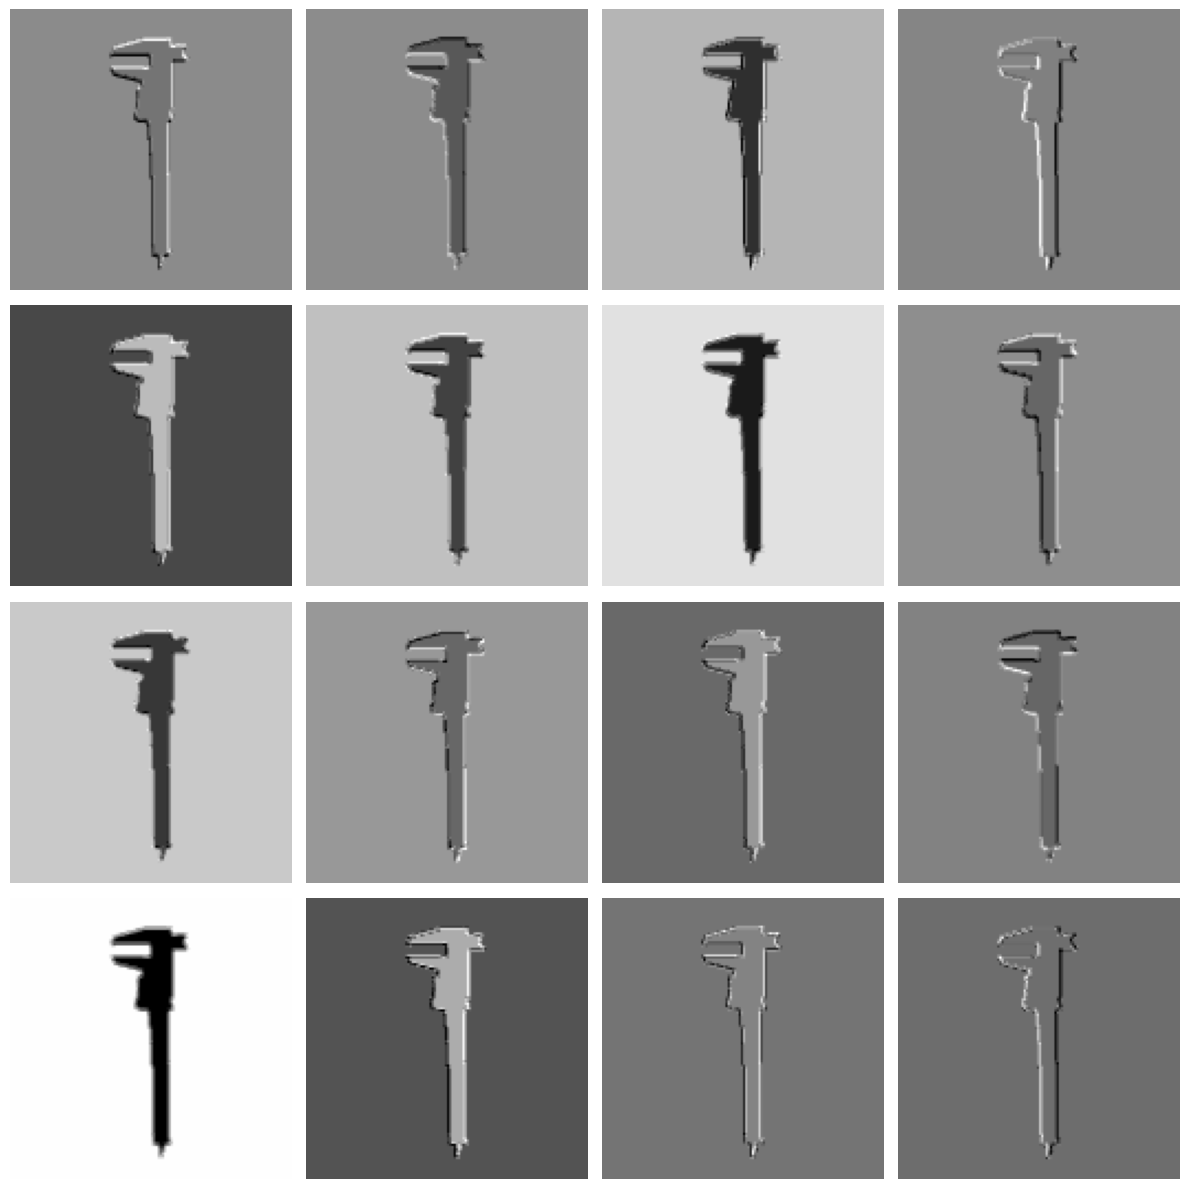

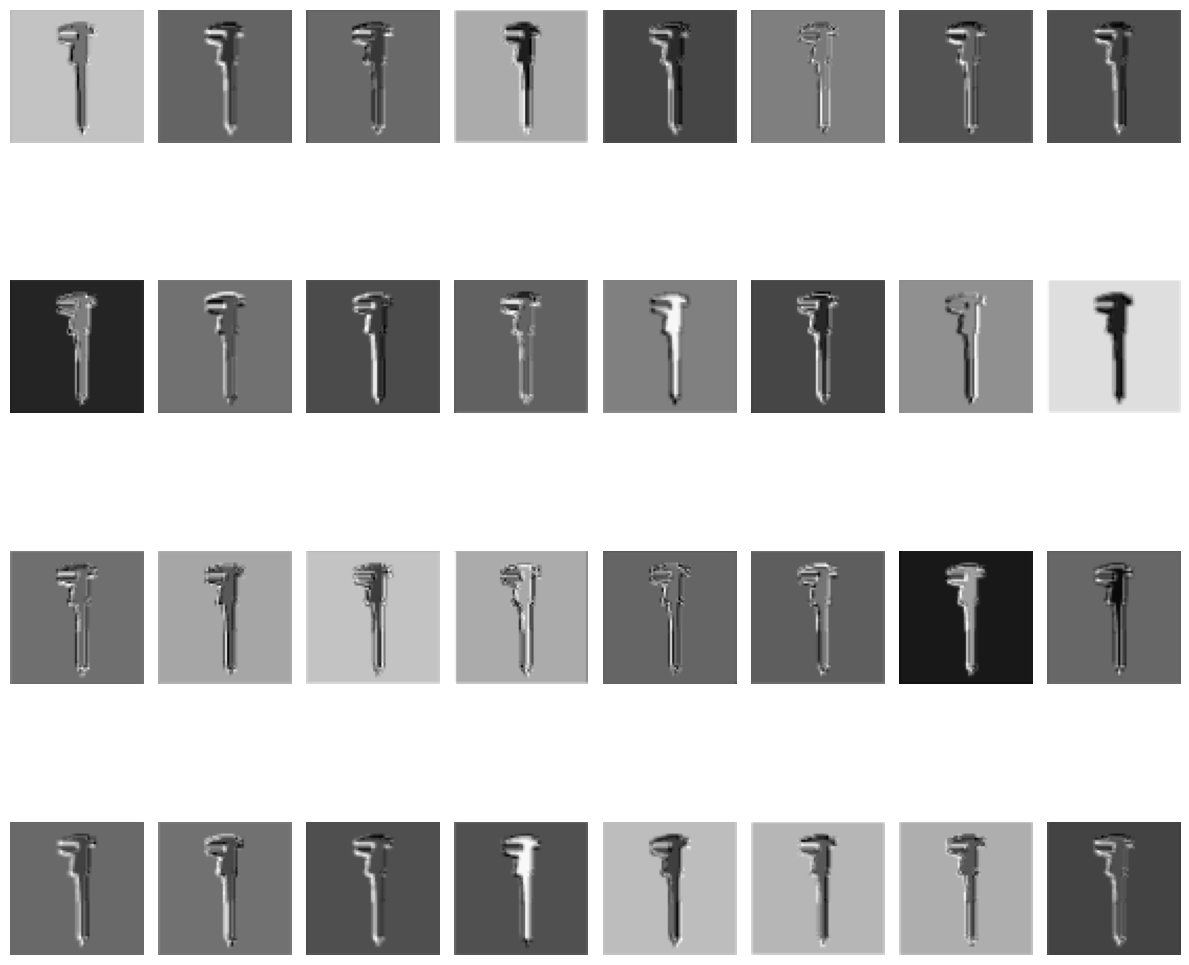

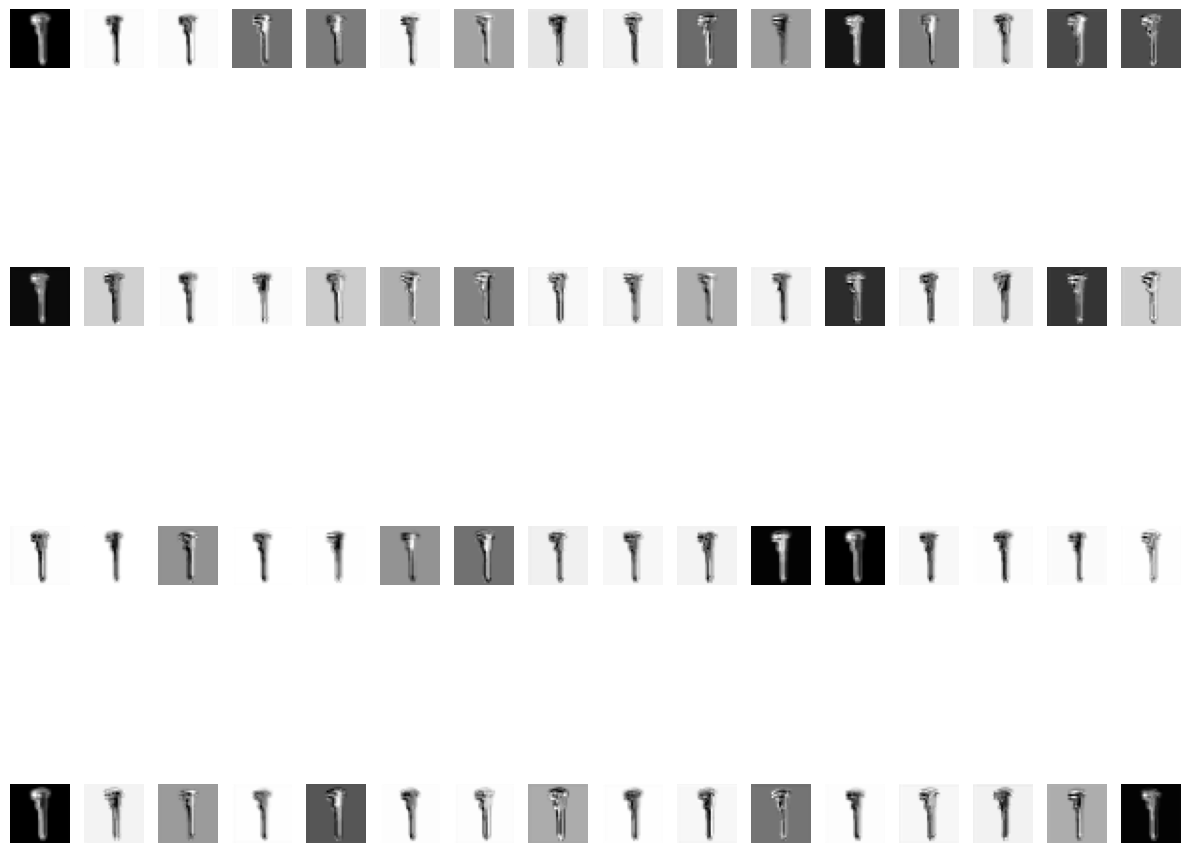

In [37]:
def plot_feature_maps(feature_maps, ncols=4, cmap='gray'):
    """
    feature_maps: torch.Tensor of shape (C, H, W)
    ncols: number of columns in the subplot
    cmap: colormap to use for imshow
    """
    n_filters = feature_maps.shape[0]
    nrows = (n_filters + ncols - 1) // ncols  # round up

    fig, axarr = plt.subplots(nrows, ncols, figsize=(12, 12))
    axarr = axarr.flat if nrows > 1 else [axarr]  # handle 1D vs 2D array of axes

    for i in range(n_filters):
        # Convert each channel to CPU numpy if on GPU
        axarr[i].imshow(feature_maps[i], cmap=cmap)
        axarr[i].axis('off')

    # Hide unused subplots if any
    for j in range(i+1, nrows*ncols):
        axarr[j].axis('off')

    plt.tight_layout()
    plt.show()

# Suppose feature_map has shape (16, 128, 128)
# Just call the function:
plot_feature_maps(observer.features_maps[0], ncols=4)
plot_feature_maps(observer.features_maps[1], ncols=8)
plot_feature_maps(observer.features_maps[2], ncols=16)

In [4]:
import cv2
import os
from DataSet_editor import DataSet_editor

image_dir = "/home/pablo_kevin/ProyectoTecnologo_RoboticHandDRL/Desarrollo/simulation/Env03/DataSets/B&W_Tools"
tools_of_interest = [f for f in os.listdir(image_dir)]
print(tools_of_interest)
num_images = len(tools_of_interest)
print(num_images)
random_index = np.random.randint(0, num_images)
print(random_index)
selected_image_path = os.path.join(image_dir, tools_of_interest[random_index])

img = cv2.imread(selected_image_path, cv2.IMREAD_GRAYSCALE)

editor = DataSet_editor()
img = editor.transform_image(img)

img[img < 255/2] = 0  
img[img >=  255/2] = 1
img = np.expand_dims(img, axis=0)

['bw_Lapicera01.png', 'bw_destornillador02.png', 'bw_destornillador01.jpg', 'bw_martillo02.png', 'bw_pinza_chica01.png', 'bw_Martillo01.jpg', 'bw_tornillo02.png', 'bw_destornillador03.png', 'bw_calibre01.png', 'bw_lapicera02.png', 'empty.png', 'bw_tornillo01.jpg', 'bw_lapicera03.png', 'bw_tornillo03.png', 'bw_pinza_grande01.png']
15
0


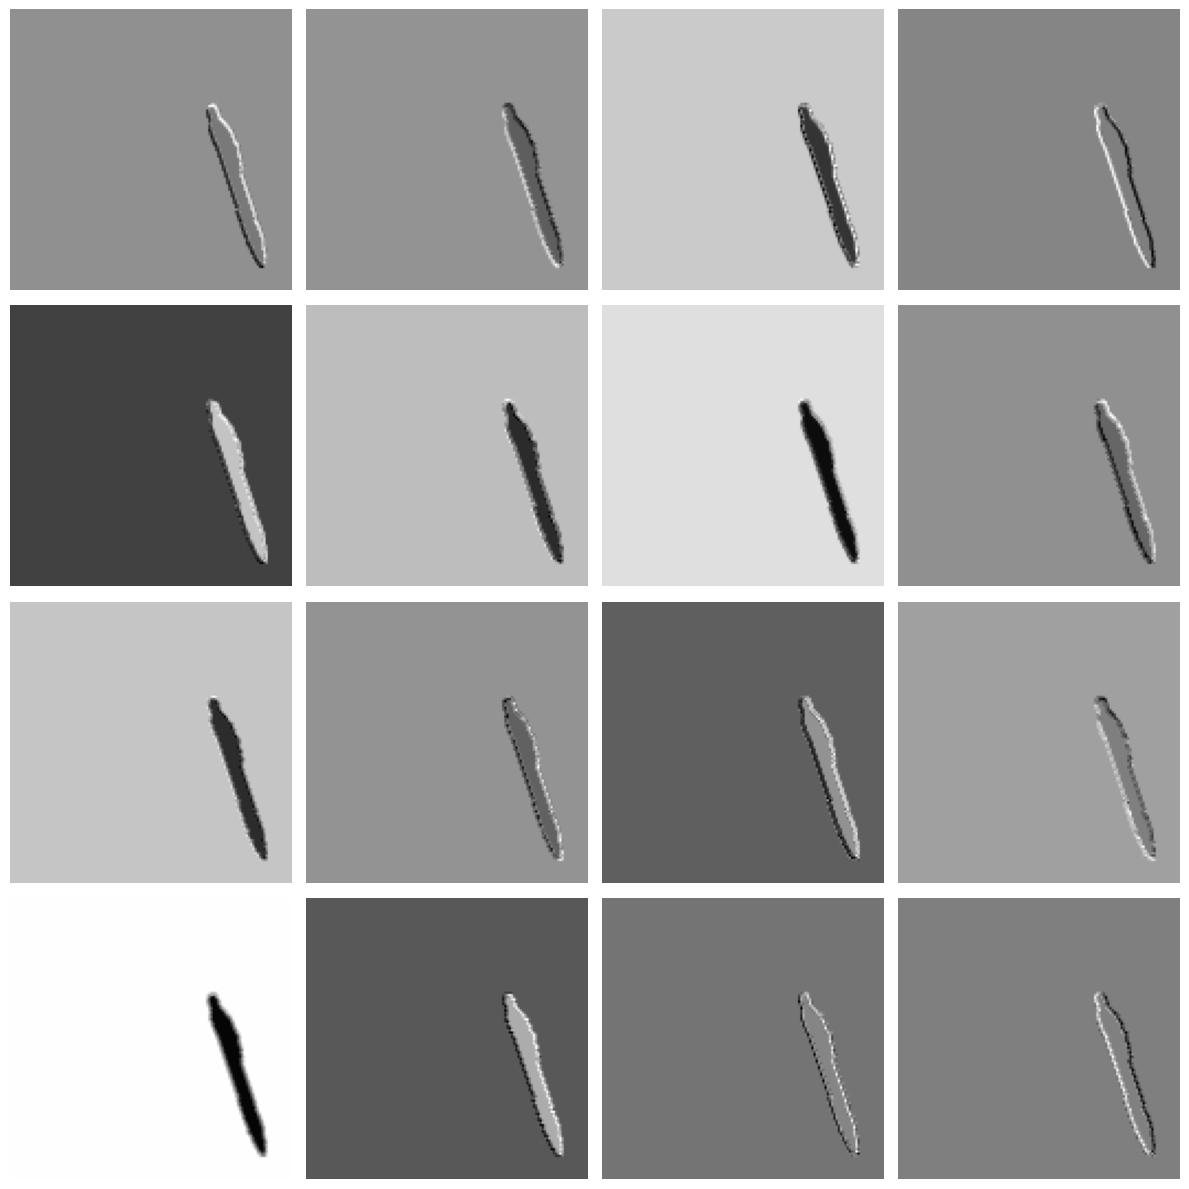

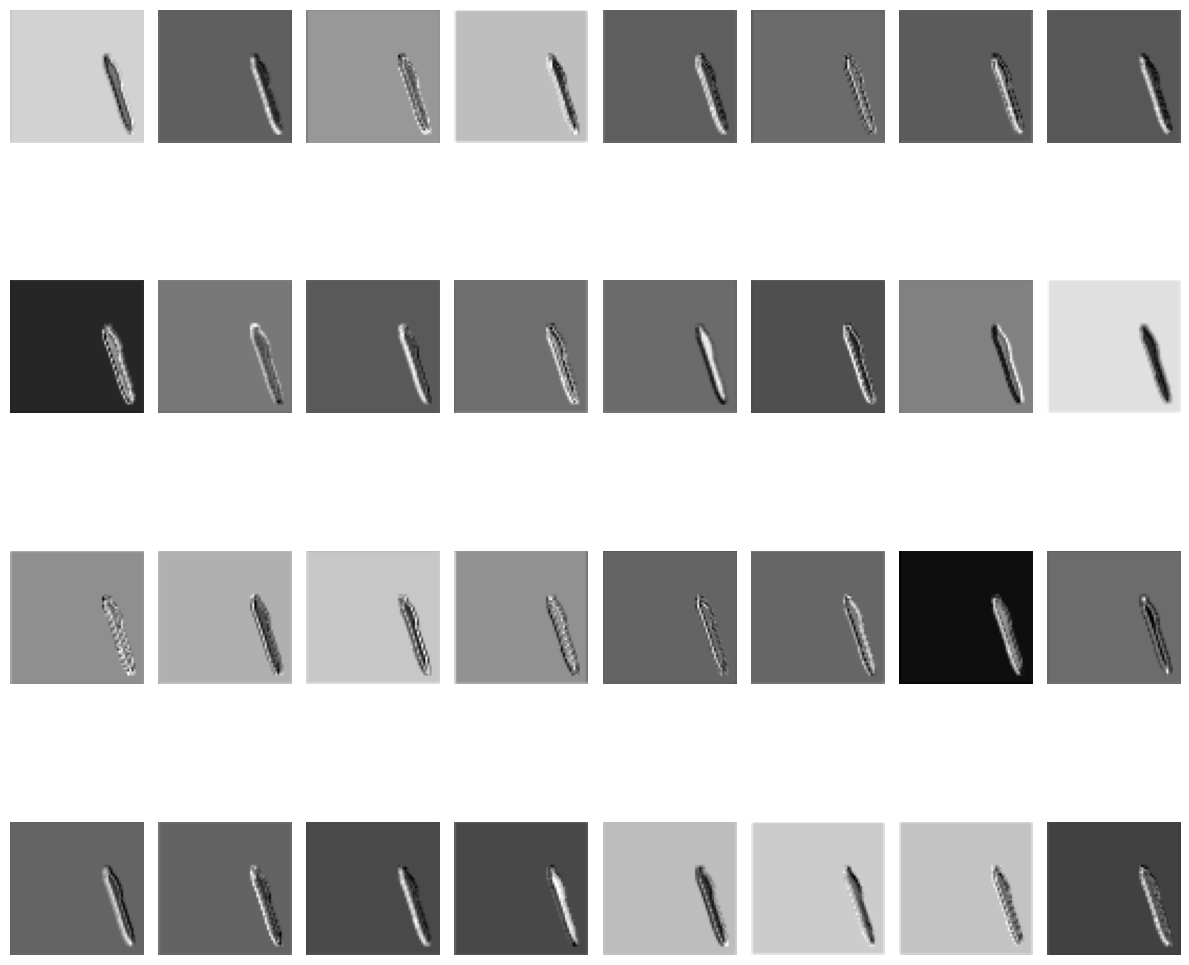

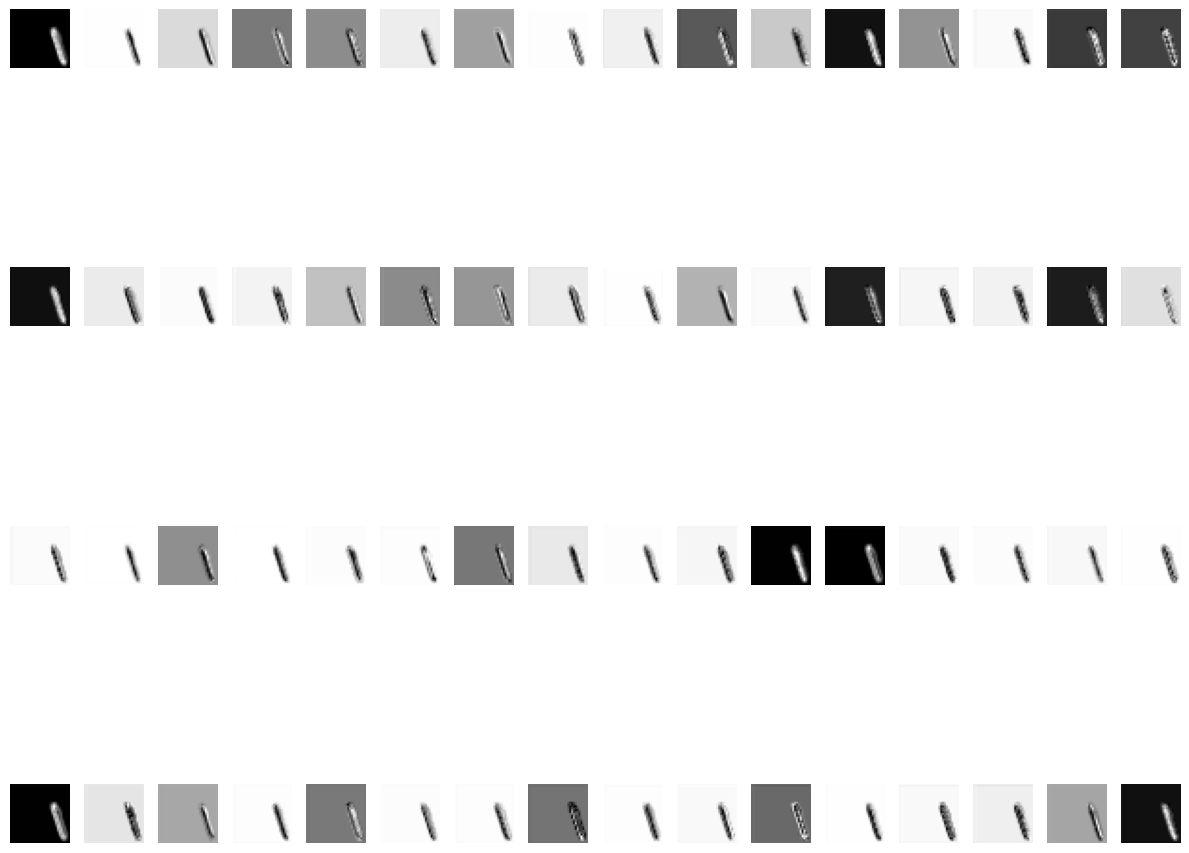

In [91]:
observer(img)
plot_feature_maps(observer.features_maps[0], ncols=4)
plot_feature_maps(observer.features_maps[1], ncols=8)
plot_feature_maps(observer.features_maps[2], ncols=16)

In [107]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import numpy as np

import matplotlib.pyplot as plt

# Observer Network
class ObserverNetwork(nn.Module):
    # Devuelve la acción a tomar en función del estado
    def __init__(self, input_dims = (256, 256, 3), output_dims = 1, conv_channels=[16, 32, 64], hidden_layers=[64,8], name='observer', checkpoint_dir='Desarrollo/simulation/Env03/tmp/observer', learning_rate=0.001):
        super(ObserverNetwork, self).__init__()
        self.input_dims = input_dims
        self.output_dims = output_dims
        self.checkpoint_dir = checkpoint_dir
        self.name = name
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name+'_supervised')
        self.features_maps = [None, None, None]

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=conv_channels[0], kernel_size=5, stride=2, padding=2)
        self.conv2 = nn.Conv2d(in_channels=conv_channels[0], out_channels=conv_channels[1], kernel_size=5, stride=2, padding=2)
        self.conv3 = nn.Conv2d(in_channels=conv_channels[1], out_channels=conv_channels[2], kernel_size=5, stride=2, padding=2)
        self.fc1 = nn.Linear(conv_channels[2] * (input_dims[0] // 8) * (input_dims[1] // 8), hidden_layers[0])
        self.fc2 = nn.Linear(hidden_layers[0], hidden_layers[1])
        self.fc3 = nn.Linear(hidden_layers[1], output_dims)
        
        self.optimizer = optim.AdamW(self.parameters(), lr=learning_rate)
        
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        print(f"Created Observer Network on device: {self.device}")
        self.to(self.device)
        

    def forward(self, img):
        img = torch.tensor(img, dtype=torch.float).permute((2,0,1)).to(self.device)
        filters_1 = self.conv1(img)
        x = F.leaky_relu(filters_1)
        filters_2 = self.conv2(x)
        x = F.leaky_relu(filters_2)
        filters_3 = self.conv3(x)
        x = F.leaky_relu(filters_3)

        
        self.features_maps[0] = filters_1.cpu().detach().numpy()
        self.features_maps[1] = filters_2.cpu().detach().numpy()
        self.features_maps[2] = filters_3.cpu().detach().numpy()
        #print(f"Shape after conv3: {x.shape}")
        # Check if the input is a batch or a single image
        if len(x.shape) == 4:  # Batch case: [batch_size, channels, height, width]
            x = x.reshape((x.size(0), -1))  # Flatten each sample in the batch
        elif len(x.shape) == 3:  # Single image case: [channels, height, width]
            x = x.reshape(-1)  # Flatten the single image
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        tool_reg = F.leaky_relu(self.fc3(x))
            
        return tool_reg # Tool regresion

    def save_checkpoint(self):
        torch.save(self.state_dict(), self.checkpoint_file)

    def load_model(self):
        self.load_state_dict(torch.load(self.checkpoint_file))
        print("Successfully loaded observer model")

In [108]:
observer = ObserverNetwork(input_dims=(256,256,3), checkpoint_dir="./tmp/observer")
observer.load_model()

Created Observer Network on device: cuda:0


/tmp/ipykernel_11422/3397738743.py:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(self.checkpoint_file))


RuntimeError: Error(s) in loading state_dict for ObserverNetwork:
	size mismatch for conv1.weight: copying a param with shape torch.Size([16, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([16, 3, 5, 5]).

In [98]:
image_dir = "/home/pablo_kevin/ProyectoTecnologo_RoboticHandDRL/Desarrollo/simulation/Env03/DataSets/RawTools"
tools_of_interest = [f for f in os.listdir(image_dir)]
print(tools_of_interest)
num_images = len(tools_of_interest)
print(num_images)
random_index = np.random.randint(0, num_images)
print(random_index)
selected_image_path = os.path.join(image_dir, tools_of_interest[random_index])

img = cv2.imread(selected_image_path)

#editor = DataSet_editor()
#img = editor.transform_image(img)

#img[img < 255/2] = 0  
#img[img >=  255/2] = 1
#img = np.expand_dims(img, axis=0)
print(img.shape)

['Martillo01.jpg', 'tornillo02.png', 'destornillador02.png', 'destornillador03.png', 'calibre01.png', 'destornillador01.jpg', 'lapicera02.png', 'pinza_grande01.png', 'lapicera03.png', 'tornillo01.jpg', 'tornillo03.png', 'Lapicera01.png', 'pinza_chica01.png', 'martillo02.png']
14
13
(256, 256, 3)


In [105]:
observer(img)
plot_feature_maps(observer.features_maps[0], ncols=4)
plot_feature_maps(observer.features_maps[1], ncols=8)
plot_feature_maps(observer.features_maps[2], ncols=16)

RuntimeError: Given groups=1, weight of size [16, 1, 5, 5], expected input[1, 3, 256, 256] to have 1 channels, but got 3 channels instead

## Usando YOLO para segmentación de imágenes.

In [7]:
from ultralytics import YOLO
import random
import cv2
import numpy as np

model = YOLO("yolo11n-seg.pt") #"yolov8n-seg.pt"

img = cv2.imread("./DataSets/RawTools/Lapicera01.png")


# if you want all classes
#yolo_classes = list(model.names.values())
#classes_ids = [yolo_classes.index(clas) for clas in yolo_classes]

conf = 0.3

results = model.predict(img, conf=conf)
#colors = [random.choices(range(256), k=3) for _ in classes_ids]
print(results)
for result in results:
    for mask, box in zip(result.masks.xy, result.boxes):
        points = np.int32([mask])
        # cv2.polylines(img, points, True, (255, 0, 0), 1)
        #color_number = classes_ids.index(int(box.cls[0]))
        cv2.fillPoly(img, points, (0,0,255))

cv2.imshow("Image", img)
cv2.waitKey(5000)


0: 640x640 1 airplane, 4.3ms
Speed: 1.3ms preprocess, 4.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: ultralytics.engine.results.Masks object
names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'appl

-1